# The Dynamics of an Ion Chain in a Harmonic Potential  
This Notebook follows the paper of the same name by Giovanna Morigi and Shmuel Fishman  
arXiv:cond-mat/0407675v1 [cond-mat.stat-mech] 26 July 2004

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import scipy.optimize as optimize

In [2]:
%%HTML
<img src="http://www.newswise.com/images/uploads/2012/03/19/29_laser_cooled_ion_chain.jpg"
<h1>1D Coulomb Chain</h1>

## Equilibrium Positions  
The paper by Morigi and Fishman describe one-dimensional chains with a large transverse confinement.  The axial direction is given as $x$, and the system possesses rotational symmetry about $\hat{x}$  
Per the paper, the Hamiltonian of the chain of $N$ ions with mass $m$ and charge $Q$ confined by harmonic potentials characterized by $\nu$ along the x-axis and $\nu_t$ in the transverse directions is given by  

$$H = \sum_{j=1}^{N} \frac{\mathbf{p}^2_j}{2m} + V\left(\mathbf{r}_1, \cdots ,\mathbf{r}_N\right)$$  
where the potential is given by $$V=\sum_j \frac{1}{2} m \left(\nu^2x_j^2 + \nu_t^2 \left(y_j^2+z_j^2 \right)\right) + \frac{1}{2} \sum_j \sum_{i,i\neq j} \frac{k_eQ^2}{\sqrt{\left(x_i - x_j\right)^2 +\left(y_i - y_j\right)^2 +\left(z_i - z_j\right)^2}} $$  

where $\mathbf{r}_j = \left(x_j,y_j,z_j\right)$ and $\mathbf{p}_j$ are the positions and conjugate momenta of the $j^{th}$ ion.  
At low temperatures and an asymmetric trap such that $\nu \ll \nu_t$, the ions are confined along the trap axis, as shown in the image above, and we find the equilibrium positions by minimizing the potential energy.  

To generate the ion chain, we first create an ion trap object and borrow shamelessly from [Dominic Meiser's mode analysis code](https://github.com/d-meiser/ion-trapping-notes/blob/master/mode_analysis_code.py).

I need to figure out how to work in Potential energy.
* Do I use dimensionless units?
* Should I make this apply for any general position vector, or just the equilibrium states?  
    * Yes, just use initial array along x-axis for equilibrium corrections
    * Correction: I need to make sure this method does not result in ions migrating away from $x=0$.  
    
* Let $x_j = \ell X_j$:
    
$$ V = \frac{m \nu^2 \ell^2}{2} \left[\sum_j X_j^2 + \frac{\nu_T^2}{\nu^2} \left(Y_j^2+Z_j^2\right) + \frac{k_eQ^2}{m \nu^2 \ell^3} \sum_j \sum_{i, i \neq j}\left[ \frac{1}{R_{i,j}}\right]\right]$$

* Since $\ell^3 \equiv \frac{k_e Q^2}{m \nu^2}$, the coefficient of the coulomb term reduces to $\frac{k_e Q^2}{m \nu^2 \frac{k_e Q^2}{ m \nu^2}} = 1$
* $m = m_{Be}$  
* $E_0 \equiv \frac{m \nu^2 \ell^2}{2}$
* Recheck this math  
* Work on generate chain next (basically linspace?)
* After generate chain, minimize potential energy to find equilibrium positions
* Expand potential to quadratic terms, get hamiltonian, dp/dt = dH/dq get eq of motion
* Convert N eqs of motion to 2N eqs of motion
* Convert 2N eqs into matrix
* solve for eigenvalues of matrix
* Plot eigenvalues w1, w2, etc, against axial and transverse frequency
* Profit  

We modified the 3d potential energy calculation to consider only potentials where the ions lie along the x axis.  This simplifies the calculation, but will it have an effect when I try to evolve the system?  For this problem, I will not be evolving the chain, but rather looking only at axial and transverse eigenvalues.  Time Evolution should not be necessary for this purpose

Letting $V = E_0 \bar{V}$, the nondimensional potential is given by $$ \bar{V} = \sum_j X_j^2 +  \sum_j \sum_{i,i \neq j} \frac{1}{\sqrt{\left(X_i - X_j\right)^2}}$$  
* Double counting issues were taken care of by the $\frac{1}{2}$ that was factored out in nondimensionalization.  

We need to have the Jacobian and Hessian matricies for use in $\texttt{scipy.optimize.minimize}$, so we need to get the first and second order derivatives in $X_i$  


Since we have a double sum, we notice that $X_k$ appears twice for each $k$ in the Coulomb Term: Once as the 'primary' and $N_{ion}$ times as the 'secondary' (for each $R_{ij}$ there is another $R_{ji}$ term, so we need to double the derivative of the Coulomb term):

$$
\begin{align}
\partial_k \bar{V} &= 2X_k -\frac{1}{2} \left(\left(X_1-X_k\right)^2\right)^{-3/2} 2\left(X_1-X_k\right)(-1) + \cdots + -\frac{1}{2} \left(\left(X_k-X_1\right)^2\right)^{-3/2} 2\left(X_k-X_1\right)(1) + \cdots \\
&= 2X_k + \frac{X_1-X_k}{\left(\left(X_1-X_k\right)^2\right)^{3/2}} - \frac{X_k-X_1}{\left(\left(X_k-X_1\right)^2\right)^{3/2}} + \cdots \\
& = 2X_k + \sum_{i,i \neq k} \frac{X_i-X_k}{\left(\left(X_i-X_k\right)^2\right)^{3/2}} + \frac{X_i-X_k}{\left(\left(X_i-X_k\right)^2\right)^{3/2}} \\
 & = 2X_k + 2 \sum_{i,i \neq k} \frac{X_i-X_k}{\left(\left(X_i-X_k\right)^2\right)^{3/2}}
 \end{align}
$$  

The second derivatives are less tricky.  Since the first derivitive reduces $\bar{V}$ to only terms containing $X_k$, we have many fewer terms, and each term in the sum is differentiated in $\partial_{kk}$, but only one term is differentiated in $\partial_{kl}$
$$
\begin{align}
\partial_{kk} \bar{V} & = 2 + 2 \sum_{i \neq k} (-1) \left(\left(X_i-X_k\right)^2\right)^{-3/2} - \frac{3}{2} \left(X_i-X_k\right)\left(\left(X_i - X_k\right)^2\right)^{-5/2} 2 \left(X_i - X_k\right)(-1)\\
 & = 2 + 2 \sum_{i \neq k} \frac{-1}{\left(\left(X_i-X_k\right)^2\right)^{3/2}} + \frac{3 \left(X_i-X_k\right)^2}{\left(\left(X_i-X_k\right)^2\right)^{3/2} \left(X_i-X_k\right)^2} \\
  & = 2 + 4 \sum_{i \neq k} \frac{1}{\left(\left(X_i-X_k\right)^2\right)^{3/2}}\\
\end{align}
$$  
While the mixed derivatives operate on only one term in the first derivative:
$$
\begin{align}
\partial_{lk} \bar{V} & =  2 \left[ \frac{1}{\left(\left(X_l-X_k\right)^2\right)^{3/2}} - \frac{3 \left(X_l-X_k\right)^2}{\left(\left(X_l-X_k\right)^2\right)^{3/2} \left(X_l-X_k\right)^2} \right] \\
 & = \frac{-4}{\left(\left(X_l-X_k\right)^2\right)^{3/2}}
\end{align}
$$

For the Jacobian, we need to remember that our minimization is over the individual positions of the ions.  As such, we are attempting to find the vector $\vec{\bf{r_0}}$ that minimizes the total energy of all of the ions in the potential $V$.  Since the Jacobian $\bf{J}_{ij} = \frac{\partial f_i}{\partial x_j}$ is acting on a scalar potential $V$, the Jacobian is a row vector of the derivatives of $V$ wrt their individual positions.  
* I am going to give the function the positive Jacobian, rather than the negative jacobian (forces on each ion), and see how this turns out.  If I want to change this, I will just use "return -J" instead of "return J"
** After looking at Adam's code, his 'force_penning' does not return the force, but rather the negative force, and can therefore be used as the Jacobian (9/6)

We redefine our axial variables to $q_i = x_i - x_i^{(0)}$, and we approximate our Hamiltonian to second order: $H \approx V_0 + H_{har}$  

##### 11/28

Since we are dealing with $N$ ions, each of which is characterized by 3 spatial variables, we redefine our coordinates to $x_n^\alpha$, where $n = 1,2,3,\cdots,N$ and $\alpha = 1,2,3$, such that $x_3^2 = y_3$  

We can taylor expand any function $f$ about its equilibrium in a taylor series expansion to second order:  
$$ f \left(x_i^{\alpha}\right) = f\left(\bf{r}^{(0)}\right) + \partial_{x_1^1} f\left(\bf{r}^{(0)}\right) x_1^1 + \partial_{x_1^2} f\left(\bf{r}^{(0)}\right) x_1^2 + \cdots + \partial_{x_2^1} f\left(\bf{r}^{(0)}\right) x_2^1 + \cdots + \partial^2_{x_1^1 x_1^1} f\left(\bf{r}^{(0)}\right) \left(x_1^1\right)^2 + 2 \partial^2_{x_1^1 x_1^2} f\left(\bf{r}^{(0)}\right) x_1^1 x_1^2 + \cdots + 2 \partial^2_{x_1^1 x_2^1} f\left(\bf{r}^{(0)}\right) x_1^1 x_2^1 \cdots $$  

The position vector is given by $\bf{r}$,  The configuration of the system is given by the three spatial dimensions for each of $N$ ions.  This results in a $3N$ dimensional vector to define the 'position' of the system.  Since we are expanding about equilibrium, the first derivatives evaluated at the system equilibrium are necessarily zero.  Furthermore, since we are taking the second derivatives wrt each 'component' of the configuration, we take derivatives of every permutation of $x_{n_i}^{\alpha_{i}}x_{n_j}^{\alpha_{j}}$.  This means there are taking $N \cdot 3 \cdot N \cdot 3 = 9N^2$ derivatives.  However, since we are dealing with a reasonably well behaved $V$, the cross-derivatives are equal.  

|      |      |      |      |      |      |      |      |      |
|------|------|------|------|------|------|------|------|------|
| 11xx | 11yy | 11zz | 11xy | 11yx | 11xz | 11zx | 11yz | 11zy |
| 12xx | 12yy | 12zz | 12xy | 12yx | 12xz | 12zx | 12yz | 12zy |
| 21xx | 21yy | 21zz | 21xy | 21yx | 21xz | 21zx | 21yz | 21zy |
| 22xx | 22yy | 22zz | 22xy | 22yx | 22xz | 22zx | 22yz | 22zy |

As seen from the table above, representing the order of derivative as given by $n_1 n_2 \alpha_1 \alpha_2$, we see that for a given ion order (i.e. 12 or 11), there are a total of 6 distinct derivatives, as $n_1 n_2 xy$ is the same as $n_1 n_2 yx$.  The table shows these pairs as adjacent columns.  Now, we need to count how many repetitions exist in the rows:  There are $N$ rows where $n_1 = n_2$, and there are $\binom{N}{2}$ rows where $n_1 n_2 = n_2 n_1$.  This means that we really only have a total of $6\left[N + \binom{N}{2} \right]$ distinct derivatives to deal with.

Now, $$ V = \sum_{j=1}^N \sum_{i \neq j} \left[\sum_{\alpha} \left(x_i^{\alpha} - x_j^{\alpha}\right)^2\right]^{-1/2}$$  

We pick a $k\in J$, $a \in A$, and we note that each $x_k^a$ appears $2N$ times ($N$ times in $\sum_{i \neq k}$ for $j=k$, and $N$ times in $\sum_j$ for $j\neq k$).  

$$ \partial_{x_k^a} V = \sum_{j=k} \sum_{i \neq j} -\frac{1}{2} \left[\sum_{\alpha} \left(x_i^{\alpha} - x_j^{\alpha}\right)^2\right]^{-3/2} 2 \left(x_i^a - x_k^a\right) \left(-1\right) + \sum_{j \neq k} \sum_{i = k} \frac{1}{2}\left[\sum_{\alpha}\left(x_i^{\alpha} - x_j^{\alpha}\right)^2\right]^{-3/2} 2 \left(x_k^a - x_j^a\right) (1)$$  

Because the term $\left(x_i^{\alpha} - x_j^{\alpha}\right)^2$ is squared, we can swap the order without gaining a negative sign, and since the $i, j, k$ are dummy variables, we can interchange their order and pay attention to negative signs to get
Noting that $\left[\sum_{\alpha}\left(x_i^{\alpha} - x_j^{\alpha}\right)^2\right]^{1/2} = r_{ij}$, we get

$$ \partial_{x_k^a} V = \sum_{i \neq k} 2 \left(x_i^a - x_k^a\right) \left[\sum_{\alpha}\left(x_i^{\alpha} - x_k^{\alpha}\right)^2\right]^{-3/2}$$


##### 12/5  
We should switch coordinates to coordinates based on the equilibrium, such that $q_i = 0$ at equilibrium.  Since $y_i=0$ and $z_i=0$, the only change needs to be $x_i = x_i^{(0)} + q_i \Rightarrow q_i = x_i - x_i^{(0)}$  

Since this is only a translation, $\partial x_i = \partial q_i$, and we can replace $x_i - x_j \mapsto q_i-q_j - \Delta x_{ij}$:  
$$
\begin{align*}
x_i - x_j &= q_i - x_i^{(0)} - q_j + x_j^{(0)} \\
&= q_i-q_j -\left(x_i^{(0)} - x_j^{(0)}\right) \\
&= q_i-q_j - \Delta x_{ij}
\end{align*}
$$  
Since we are really evaluating all our derivatives at equilibrium, our end result is:
$$r_{ij}\rvert_{eq} = \left(x_i - x_j\right)_{eq} = \Delta x_{ij}$$ 


When we take our second derivative, we have four choices as to how we choose which variable:  $x_k^a, x_k^b, x_j^a, x_j^b$  

$x_k^a$:  
$$
\begin{align*}
\partial_{x_k^a}^2 V &= \sum_{i \neq k} 2 \left( x_i^a - x_k^a \right) \frac{-3}{2} \left[\sum_{\alpha}\left(x_i^{\alpha} - x_k^{\alpha}\right)^2\right]^{-5/2} 2 \left(x_i^{a} - x_k^{a}\right) (-1) + 2 (-1) \left[\sum_{\alpha}\left(x_i^{\alpha} - x_k^{\alpha}\right)^2\right]^{-3/2}\\
&= 2\left[ \sum_{i \neq k} 3 \left(x_i^a-x_k^a \right)^2 \left(r_{ik}^2\right)^{-5/2} - \left(r_{ik}^2\right)^{-3/2}\right]\\
&= 2 \sum_{i \neq k} \left[3 \left( x_i^a - x_k^a \right)^2 \left|r_{ik}\right|^{-5} -  \left|r_{ik}\right|^{-3}\right]\\
\end{align*}
$$
Evaluating this at equilibrium, we get
$$
\partial_{x_k^a}^2 V\rvert_{eq} = \left\{
    \begin{array}{ll}
        4 \sum_{i \neq k} \Delta \left|x_{ij}\right|^{-3} & \quad a=1\\
        -2 \sum_{i \neq k} \Delta \left|x_{ij}\right|^{-3} & \quad a \neq 1
    \end{array}
    \right.
$$

$x_k^b$:
$$
\begin{align*}
\partial_{x_k^b} \partial_{x_k^a} V &= \sum_{i \neq k} 2 \left( x_i^a - x_k^a \right) \frac{-3}{2} \left[\sum_{\alpha}\left(x_i^{\alpha} - x_k^{\alpha}\right)^2\right]^{-5/2} 2 \left(x_i^{b} - x_k^{b}\right) (-1)\\
&= 6 \sum_{i \neq k} \left( x_i^a - x_k^a \right) \left(x_i^{b} - x_k^{b}\right) \left[r_{ik}^2\right]^{-5/2}
\end{align*}
$$

Evaluating at equilibrium:

$$
\partial_{x_k^b x_k^a}V\rvert_{eq} = 0
$$
since $a \neq b$, at least one must represent the $y-$ or $z-$ coordinate, and at equilibrium, these two coordinates are equal, and so one of the $\left(x_i^{\alpha}-x_k^{\alpha}\right)=0$ 

$x_j^b$:
$$
\begin{align*}
\partial_{x_j^b} \partial_{x_k^a} V &=  2 \left( x_i^a - x_k^a \right) \frac{-3}{2} \left[\sum_{\alpha}\left(x_i^{\alpha} - x_k^{\alpha}\right)^2\right]^{-5/2} 2 \left(x_j^{b} - x_k^{b}\right) (1)\\
&= -6 \left( x_i^a - x_k^a \right) \left(x_j^{b} - x_k^{b}\right) \left[r_{ik}^2\right]^{-5/2}
\end{align*}
$$

Evaluating at equilibrium:

$$
\partial_{x_j^b x_k^a}V\rvert_{eq} = 0
$$
Since one of the two differences must be zero, as before.

$x_j^a$:

$$
\begin{align*}
\partial_{x_j^a x_k^a} V &= 2 \left(x_j^a - x_k^a \right) \frac{-3}{2} \left[\sum_{\alpha}\left(x_j^{\alpha} - x_k^{\alpha}\right)^2\right]^{-5/2} 2 \left(x_j^a - x_k^a \right) (1) + 2 \left[\sum_{\alpha}\left(x_j^{\alpha} - x_k^{\alpha}\right)^2\right]^{-3/2}\\
&= 2 \left[-3 \left(x_j^a - x_k^a \right)^2 \left[\sum_{\alpha}\left(x_j^{\alpha} - x_k^{\alpha}\right)^2\right]^{-5/2} + \left[\sum_{\alpha}\left(x_j^{\alpha} - x_k^{\alpha}\right)^2\right]^{-3/2} \right]\\
&= 2 \left[-3 \left(x_j^a - x_k^a \right)^2 \left[r_{jk}^2\right]^{-5/2} + \left[r_{jk}^2\right]^{-3/2} \right]\\
&= 2 \left[-3 \left(x_j^a - x_k^a \right)^2 \left|r_{jk}\right|^{-5} + \left|r_{jk}\right|^{-3} \right]
\end{align*}
$$

Evaluating at equilibrium,

$$
\begin{align*}
\partial_{x_j^a x_k^a} V\rvert_{eq} &= 2 \left[-3 \left| \Delta x_{jk} \right|^2 \delta_{1a} \left| \Delta x_{jk} \right|^{-5} + \left| \Delta x_{jk} \right|^{-3} \right]\\
&= 2 \left[-3 \left| \Delta x_{jk} \right|^{-3} \delta_{1a} + \left| \Delta x_{jk} \right|^{-3} \right]\\
\partial_{x_j^a x_k^a} V\rvert_{eq}&= \left\{
    \begin{array}{ll}
        4 \sum_{i \neq k} \Delta \left|x_{ij}\right|^{-3} & \quad a=1\\
        -2 \sum_{i \neq k} \Delta \left|x_{ij}\right|^{-3} & \quad a \neq 1
    \end{array}
    \right.
\end{align*}
$$

In [ ]:
def eigenmodes(self, eq_array):
    x = pos_array
    dx = x.reshape((x.size-1))-x
    rsep = np.sqrt(dx**2)
    
    with np.errstate(divide='ignore'):
        rsep3 = np.where(rsep!=0., rsep**(-3),0)
        
    

My derivatives seem to agree with those found by morigi and fishman, with the possible exception of a constant factor.  Otherwise, the derivatives are equal to each other.  Note, for the Kij in the paper, the evaluated derivatives that are coefficient of the x term (a=1), are positive and twice as large as the coefficients of the y- and z- terms, which are negative.  The factor may resolve itself in the taylor expansion

Question:  for the x eigenmodes, do I use equation 6?  How does that equation produce the eigenmodes?

$$ \partial_{x_k^a} V = \sum_{i \neq k} 2 \left(x_i^a - x_k^a\right) \left[\sum_{\alpha}\left(x_i^{\alpha} - x_k^{\alpha}\right)^2\right]^{-3/2} $$

The end product of all these manipulations are the following results:

To complete our harmonic approximation, we look at the Taylor expansion:
$$
V = V\left( \vec{eq} \right) + \left(\vec{x} - \vec{eq} \right) \nabla V \rvert_{eq} + \frac{1}{2!} \left(\vec{x} - \vec{eq}\right) \cdot \left[ H \left( \vec{x} \right) \rvert_{eq} \left(\vec{x} - \vec{eq}\right)\right] + \mathscr{O} \left( \vec{x}^3 \right)
$$

$$
r^2 = x^2+y^2+z^2
$$

In [3]:
class IonChain:
    """
    Simulates a 1-dimensional Beryllium ion crystal, determining equilibrium positions
    from given axial and transverse trap parameters, and then calculates 
    eigenvectors and eigenmodes
    """
    #Establish fundamental physical constants as class variables
    q = 1.602176565E-19
    amu = 1.66057e-27
    m_Be = 9.012182 * amu
    k_e = 8.9875517873681764E9 # electrostatic constant k_e = 1 / (4.0 pi epsilon_0)

    def __init__(self, nu, nu_t, N=19, ioncharge = 2, ionmass=None, quiet=True, precision_solving=True):
        """
        :param N:       integer, number of ions
        :param quiet: will print some things if False
        :param precision_solving: Determines if perturbations will be made to the chain to find
                                    a low energy state with a number of attempts based on the
                                    number of ions.
                                    Disable for speed, but recommended.
        """
        
        
        self.quiet = quiet
        self.precision_solving = precision_solving
        self.Nion = N
        self.ioncharge = ioncharge
        self.m = self.m_Be * np.ones(self.Nion)
            
        # for array of ion positions along x
        self.u0 = np.empty(self.Nion)  # initial chain
        self.u = np.empty(self.Nion)  # equilibrium positions
        
        #trap definitions
        self.nu = nu       #axial trap characteristic frequency
        self.nu_t = nu_t   #transverse trap characteristic frequency
        
        self.dimensionless()  # Make system dimensionless

        self.axialEvals = []  # Axial eigenvalues
        self.axialEvects = []  # Axial eigenvectors
        self.transEvals = []  # Transverse eigenvalues
        self.transEvects = []  # Transverse Eigenvectors
        
        self.p0 = 0    # dimensionless potential energy of equilibrium crystal
        self.r = []
        self.rsep = []
        self.dx = []
        self.dy = []
        
        self.hasrun = False
        
    def dimensionless(self):
        """
        Calculate characteristic quantities and convert to a dimensionless
        system
        """
        self.l0 = ((self.k_e * self.q ** 2) / (self.m_Be * self.nu ** 2)) ** (1 / 3) # characteristic length
        self.t0 = 1 / self.nu  # characteristic time
        self.v0 = self.l0 / self.t0  # characteristic velocity
        #self.E0 = 0.5*self.m_Be*(self.nu**2)*self.l0**2 # characteristic energy
        self.w = self.nu_t/self.nu # scaled transverse frequency
        self.md = self.m / self.m_Be  # dimensionless mass
        
    def generate_chain(self, meth):
        """
        Generate the initial lattice for the instance in question
        """
        self.u0 = np.linspace(-.5*(self.Nion-1), .5*(self.Nion-1), self.Nion)

        self.u = self.find_eq_pos(self.u0, method = meth)
        self.u = np.append(self.u,np.zeros(self.u.size))

        return self.u
        
        
    def pot_energy(self, pos_array):
        """
        Computes the potential energy of the ion chain in one dimension(dimensionless)
        
        :param pos_array: The position vector of the ion chain (x0,x1,...,xn) (dimensionless)
        :return: The scalar potential energy of the chain configuration (in units of E0)
        """
        
        x = pos_array#[:self.Nion]
        #y = pos_array[self.Nion:2*self.Nion]
        #z = pos_array[2*self.Nion:]
        
        #dx turns 1xn pos_array into an nxn array where (row,col) represents the distance from
        #the (row)th ion to the (col)th ion
        
        dx = x.reshape((x.size,1)) - x
        #dy = y.reshape((y.size,1)) - y
        #dz = z.reshape((z.size,1)) - z
        
        #rsep is the separation distance
        rsep = np.sqrt(dx**2)# + dy**2 + dz**2)
        
        with np.errstate(divide='ignore'):
            Vc = np.where(rsep != 0 , 1/rsep, 0)
            
        V = np.sum(x**2) + np.sum(Vc)
        
        return V
    
    def chain_jacobian(self, pos_array):
        """
        Computes the jacobian for the ion chain, used in find_eq_pos
        
        :param pos_array: ion chain to find forces on
        :return: a row vector representing the derivative of V wrt position of ion i
        """
        x = pos_array
        
        dx = x.reshape((x.size,1)) - x
        
        rsep = np.sqrt(dx**2)
        
        with np.errstate(divide='ignore', invalid='ignore'):  # get a prefactor of 1/rsep^2
            Jc = np.where(rsep != 0, np.float64(dx*rsep**(-3)), 0)
            
        J = 2*x + 2*np.sum(Jc, axis = 0)
        
        return J
    
    def chain_hessian(self, pos_array):
        """
        Determines the Hessian of the potential V
        """
        x = pos_array
        dx = x.reshape((x.size,1)) - x
        rsep = np.sqrt(dx**2)
        
        with np.errstate(divide='ignore'):
            Hc = np.where(rsep != 0, rsep**(-3), 0)
            
        Hkk = np.diag(2+4*np.sum(Hc, axis = 1))
        Hlk = -4*Hc
        
        H = Hkk + Hlk
        
        return H
    
    
    def find_eq_pos(self, u0, method = 'bfgs', tolerance = 1e-34):
        """
        Runs optimization code to tweak the position vector defining the crystal to a minimum potential energy
        configuration
        
        u0: The position vector defining the crystal
        Returns the equilibrium position vector
        """
        newton_tolerance = 1e-34
        bfgs_tolerance = 1e-34
        
        if method is 'newton':
            out = optimize.minimize(self.pot_energy, u0, method = 'Newton-CG', jac = self.chain_jacobian,
                                   hess = self.chain_hessian,
                                   options = {'xtol':newton_tolerance, 'disp': not self.quiet})
            
        else:
            out = optimize.minimize(self.pot_energy, u0, method = 'BFGS', jac = self.chain_jacobian,
                                   options = {'gtol': bfgs_tolerance, 'disp':False})
            
        return out.x
    
    
    def show_chain(self, pos_vect):
        """
        Makes a pretty plot of the ion chain with a given position vector
        
        :param pos_vect: The chain position vector to be seen
        """
        
        plt. plot(pos_vect[0:self.Nion], pos_vect[self.Nion:], '.')
        plt.xlabel('Axial position')
        #plt.axes().set_aspect('equal')
        
        plt.show()
        
        
    def calc_axial_modes(self, pos_array):
        """
        Calculate the modes of axial vibration for an ion chain defined by pos_array.
        
        :param: pos_array: Position vector which defines the crystal to be analyzed
        :return: Array of Eigenvalues, array of Eigenvectors
        """
        
        x = pos_array
        dx = x.reshape((x.size),1) - x
        
        rsep = np.sqrt(dx**2)
        
        with np.errstate(divide = 'ignore'):
            rsep3 = np.where(rsep != 0., rsep**(-3),0)
            
        K = np.diag

###### November 6, 2017  


### Mistake Log:

Hessian Calculation
$$
\begin{align}
\partial_{kk} \bar{V} & = 2 - 2 \partial_k\left[\left(X_1-X_k\right) \left(\left(X_1-X_k\right)^2\right)^{-3/2} + \cdots + \left(X_k-X_1\right) \left(\left(X_k-X_1\right)^2\right)^{-3/2} + \cdots \right] \\
 &= 2 - 2 \left[(-1)\left(\left(X_1-X_k\right)^2\right)^{-3/2} + \left(-\frac{3}{2}\right)\left(X_1-X_k\right) \left(\left(X_1-X_k\right)^2\right)^{-5/2} 2\left(X_1-X_k\right)(-1) + \cdots + (1)\left(\left(X_k-X_1\right)^2\right)^{-3/2} + \left(-\frac{3}{2}\right)\left(X_k-X_1\right) \left(\left(X_k-X_1\right)^2\right)^{-5/2} 2\left(X_k-X_1\right)(1) + \cdots \right] \\  
 &= 2 - 2 \left[3 \frac{\left(X_1-X_k\right)^2}{\left(\left(X_1-X_k\right)^2\right)^{-5/2}} - 3\frac{\left(X_k-X_1\right)^2}{\left(\left(X_k-X_1\right)^2\right)^{5/2}} + \cdots \right] \text{so we get cancellation for the Coulomb terms in the diagonal}\\
 &= 2
 \end{align}
 $$  
 
* Previous problem with equilibrum positions:  I was finding that the equilibrium positions of the ions were not showing up as expected.  The ions tended to bunch up together at the ends, whereas they should be spreading out on the ends.  I fixed this by changing the axis of summation in chain_jacobian from axis = 1 to axis = 0.  
* However, it appears the process of generating a chain using BFGS results in the shuffling of ion positions.  While all values converge to the same value as for NEWTON-CG, the indexing of the array is out of order.  This shouldnt cause a problem for finding the modes, but it might need to be taken into account if this code is used for other analyses.

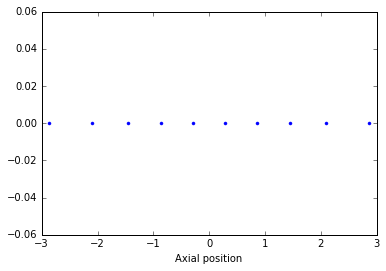

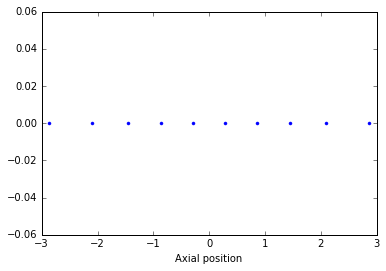

In [4]:
num = 10

a = IonChain(1000,1, N=num)
#print(a.u[0:a.Nion])
a.generate_chain('bfgs')
#print(a.u[0:a.Nion])
b = IonChain(1000,1, N=num)
b.generate_chain('newton')
#print(b.u[0:b.Nion])
a.show_chain(a.u)
b.show_chain(b.u)

#print(np.ediff1d(a.u[:a.Nion]-b.u[:b.Nion]))
#print(a.u[0:a.Nion])
#print(b.u[0:b.Nion])
plt.show()